In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

In [33]:
import sys
sys.path.insert(0, "..")   
from src.utils import (
generate_cyclical_features, 
generate_sales_features, 
add_y_targets_from_shift,
prepare_training_data_from_raw_df
)
from src.plot_util import plot_sales_histogram

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
dtype_dict={"id":np.uint32,
            "store_nbr":np.uint8,
            "item_nbr":np.uint32,
            "unit_sales":np.float32
           }
df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)
cols = ['date', 'store_item', 'store_nbr', 'item_nbr'] + [c for c in df.columns 
                                  if c not in ('date', 'store_item', 'store_nbr', 'item_nbr')]
df = df[cols]
df.rename(columns={"store_nbr": "store", "item_nbr": "item"}, inplace=True)
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)
df.head(5)



/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_74121/2905051343.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../output/data/train_top_10_store_10_item.csv", dtype=dtype_dict)


,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [5]:
df.head(5)

,date,store_item,store,item,unit_sales,onpromotion
0,2013-01-07,48_502331,48,502331,70.00000,NaN
1,2013-01-07,46_584028,46,584028,304.27301,NaN
2,2013-01-07,3_114790,3,114790,28.00000,NaN
3,2013-01-07,3_305229,3,305229,89.00000,NaN
4,2013-01-07,3_314384,3,314384,106.00000,NaN


In [6]:
df.dtypes

date           datetime64[ns]
store_item             object
store                   uint8
item                   uint32
unit_sales            float32
onpromotion            object
dtype: object

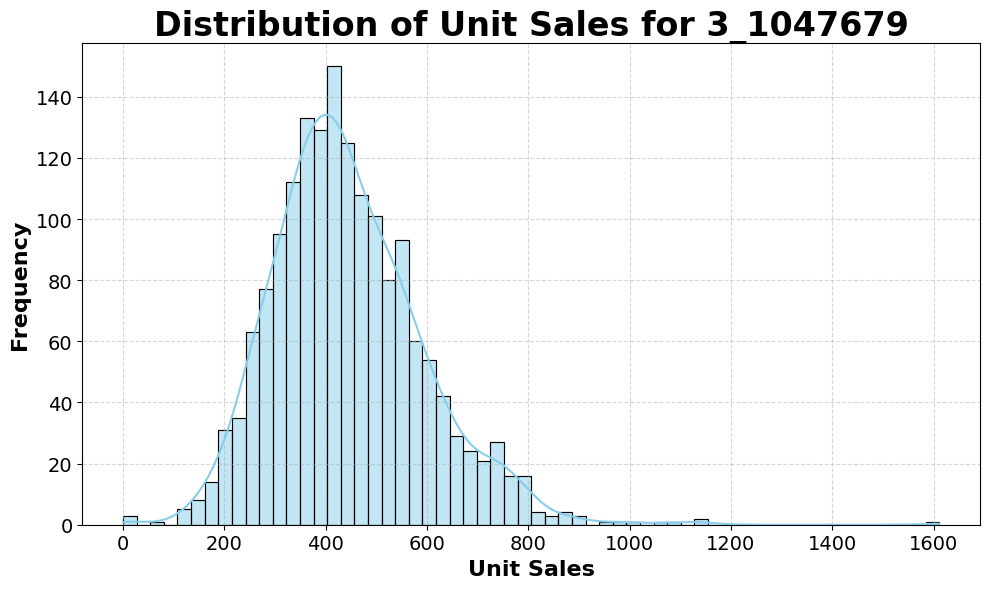

In [7]:
sid = "3_1047679"
plot_sales_histogram(df, sid=sid, bins=60, log_scale=False,fn=f"../output/figures/sales_hist_{sid}.tiff")

In [8]:
# df.to_excel("../output/data/train_top_10_store_10_item.xlsx",
#             index=False)

In [9]:
sales_df = generate_sales_features(df.query("store_item == '3_114790'"), window_size=16)
#sales_df = generate_sales_features(df.query("store_item == '3_114790' and date <= '2017-08-15'"), window_size=16)
sales_df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,item_med_day_7,item_med_day_8,item_med_day_9,item_med_day_10,item_med_day_11,item_med_day_12,item_med_day_13,item_med_day_14,item_med_day_15,item_med_day_16
0,2013-01-09,3_114790,3,114790,13.0,16.0,15.0,20.0,28.0,16.0,...,14.0,22.0,19.0,23.0,27.0,35.0,21.0,14.0,17.0,14.0
1,2013-01-25,3_114790,3,114790,17.0,18.0,37.0,13.0,16.0,20.0,...,18.0,18.0,33.0,36.0,31.0,18.0,25.0,17.0,20.0,23.0
2,2013-02-10,3_114790,3,114790,15.0,15.0,17.0,10.0,17.0,20.0,...,30.0,26.0,22.0,28.0,29.0,19.0,18.0,28.0,19.0,11.0
3,2013-02-26,3_114790,3,114790,16.0,16.0,14.0,22.0,41.0,36.0,...,24.0,18.0,24.0,17.0,19.0,38.0,35.0,23.0,20.0,20.0
4,2013-03-14,3_114790,3,114790,11.0,29.0,33.0,63.0,16.0,18.0,...,36.0,17.0,21.0,27.0,33.0,21.0,18.0,26.0,21.0,20.0


In [10]:
sales_df.columns.to_list()

['start_date',
 'store_item',
 'store',
 'item',
 'sales_day_1',
 'sales_day_2',
 'sales_day_3',
 'sales_day_4',
 'sales_day_5',
 'sales_day_6',
 'sales_day_7',
 'sales_day_8',
 'sales_day_9',
 'sales_day_10',
 'sales_day_11',
 'sales_day_12',
 'sales_day_13',
 'sales_day_14',
 'sales_day_15',
 'sales_day_16',
 'store_med_day_1',
 'store_med_day_2',
 'store_med_day_3',
 'store_med_day_4',
 'store_med_day_5',
 'store_med_day_6',
 'store_med_day_7',
 'store_med_day_8',
 'store_med_day_9',
 'store_med_day_10',
 'store_med_day_11',
 'store_med_day_12',
 'store_med_day_13',
 'store_med_day_14',
 'store_med_day_15',
 'store_med_day_16',
 'item_med_day_1',
 'item_med_day_2',
 'item_med_day_3',
 'item_med_day_4',
 'item_med_day_5',
 'item_med_day_6',
 'item_med_day_7',
 'item_med_day_8',
 'item_med_day_9',
 'item_med_day_10',
 'item_med_day_11',
 'item_med_day_12',
 'item_med_day_13',
 'item_med_day_14',
 'item_med_day_15',
 'item_med_day_16']

In [11]:
sales_df.shape

(105, 52)

In [12]:
sales_df.to_excel("../output/data/20250529_train_3_114790_sales_16_days.xlsx",
            index=False)

In [13]:
cyc_df = generate_cyclical_features(df.query("store_item == '3_114790'"), window_size=16)
cyc_df.head()

,start_date,store_item,store,item,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,...,weekofmonth_sin_15,weekofmonth_cos_15,monthofyear_sin_15,monthofyear_cos_15,dayofweek_sin_16,dayofweek_cos_16,weekofmonth_sin_16,weekofmonth_cos_16,monthofyear_sin_16,monthofyear_cos_16
0,2013-01-09,3_114790,3,114790,0.974928,-0.222521,0.587785,-0.809017,0.500000,8.660254e-01,...,-0.951057,0.309017,0.500000,8.660254e-01,0.433884,-0.900969,-9.510565e-01,0.309017,0.500000,8.660254e-01
1,2013-01-25,3_114790,3,114790,-0.433884,-0.900969,-0.951057,0.309017,0.500000,8.660254e-01,...,0.587785,-0.809017,0.866025,5.000000e-01,-0.974928,-0.222521,5.877853e-01,-0.809017,0.866025,5.000000e-01
2,2013-02-10,3_114790,3,114790,-0.781831,0.623490,0.587785,-0.809017,0.866025,5.000000e-01,...,-0.951057,0.309017,0.866025,5.000000e-01,0.000000,1.000000,-9.510565e-01,0.309017,0.866025,5.000000e-01
3,2013-02-26,3_114790,3,114790,0.781831,0.623490,-0.951057,0.309017,0.866025,5.000000e-01,...,0.587785,-0.809017,1.000000,6.123234e-17,0.974928,-0.222521,5.877853e-01,-0.809017,1.000000,6.123234e-17
4,2013-03-14,3_114790,3,114790,0.433884,-0.900969,0.587785,-0.809017,1.000000,6.123234e-17,...,-0.951057,0.309017,1.000000,6.123234e-17,-0.433884,-0.900969,-2.449294e-16,1.000000,1.000000,6.123234e-17


In [14]:
cyc_df.columns.to_list()

['start_date',
 'store_item',
 'store',
 'item',
 'dayofweek_sin_1',
 'dayofweek_cos_1',
 'weekofmonth_sin_1',
 'weekofmonth_cos_1',
 'monthofyear_sin_1',
 'monthofyear_cos_1',
 'dayofweek_sin_2',
 'dayofweek_cos_2',
 'weekofmonth_sin_2',
 'weekofmonth_cos_2',
 'monthofyear_sin_2',
 'monthofyear_cos_2',
 'dayofweek_sin_3',
 'dayofweek_cos_3',
 'weekofmonth_sin_3',
 'weekofmonth_cos_3',
 'monthofyear_sin_3',
 'monthofyear_cos_3',
 'dayofweek_sin_4',
 'dayofweek_cos_4',
 'weekofmonth_sin_4',
 'weekofmonth_cos_4',
 'monthofyear_sin_4',
 'monthofyear_cos_4',
 'dayofweek_sin_5',
 'dayofweek_cos_5',
 'weekofmonth_sin_5',
 'weekofmonth_cos_5',
 'monthofyear_sin_5',
 'monthofyear_cos_5',
 'dayofweek_sin_6',
 'dayofweek_cos_6',
 'weekofmonth_sin_6',
 'weekofmonth_cos_6',
 'monthofyear_sin_6',
 'monthofyear_cos_6',
 'dayofweek_sin_7',
 'dayofweek_cos_7',
 'weekofmonth_sin_7',
 'weekofmonth_cos_7',
 'monthofyear_sin_7',
 'monthofyear_cos_7',
 'dayofweek_sin_8',
 'dayofweek_cos_8',
 'weekofmonth_s

In [15]:
cyc_df.shape

(105, 100)

In [16]:
# Define the keys used for merging
merge_keys = ["start_date", "store_item", "store", "item"]

# Identify missing rows from non_overlap_df2 that are not in non_overlap_df
missing_from_df = sales_df.merge(
    cyc_df[merge_keys],
    on=merge_keys,
    how="left",
    indicator=True
).query('_merge == "left_only"')

# Optional: drop the merge indicator column
missing_from_df = missing_from_df.drop(columns="_merge")

# Show how many are missing
print(f"Missing rows in non_overlap_df: {missing_from_df.shape[0]}")


Missing rows in non_overlap_df: 0


In [18]:
cyc_df.to_excel("../output/data/20250529_train_3_114790_cyclical_features_16_days.xlsx",
            index=False)

In [19]:
merged_df = pd.merge(sales_df, cyc_df, on=["store_item", "start_date", "store", "item" ])
merged_df.head()

,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,weekofmonth_sin_15,weekofmonth_cos_15,monthofyear_sin_15,monthofyear_cos_15,dayofweek_sin_16,dayofweek_cos_16,weekofmonth_sin_16,weekofmonth_cos_16,monthofyear_sin_16,monthofyear_cos_16
0,2013-01-09,3_114790,3,114790,13.0,16.0,15.0,20.0,28.0,16.0,...,-0.951057,0.309017,0.500000,8.660254e-01,0.433884,-0.900969,-9.510565e-01,0.309017,0.500000,8.660254e-01
1,2013-01-25,3_114790,3,114790,17.0,18.0,37.0,13.0,16.0,20.0,...,0.587785,-0.809017,0.866025,5.000000e-01,-0.974928,-0.222521,5.877853e-01,-0.809017,0.866025,5.000000e-01
2,2013-02-10,3_114790,3,114790,15.0,15.0,17.0,10.0,17.0,20.0,...,-0.951057,0.309017,0.866025,5.000000e-01,0.000000,1.000000,-9.510565e-01,0.309017,0.866025,5.000000e-01
3,2013-02-26,3_114790,3,114790,16.0,16.0,14.0,22.0,41.0,36.0,...,0.587785,-0.809017,1.000000,6.123234e-17,0.974928,-0.222521,5.877853e-01,-0.809017,1.000000,6.123234e-17
4,2013-03-14,3_114790,3,114790,11.0,29.0,33.0,63.0,16.0,18.0,...,-0.951057,0.309017,1.000000,6.123234e-17,-0.433884,-0.900969,-2.449294e-16,1.000000,1.000000,6.123234e-17


In [20]:
merged_df.shape


(105, 148)

In [21]:
merged_df.to_excel("../output/data/20250529_train_3_114790_sales_cyclical_features_16_days.xlsx",
            index=False)

In [22]:
final_df = add_y_targets_from_shift(merged_df, window_size=16)
# y_cols = [col for col in final_df.columns if col.startswith("y_")]
# final_df = final_df.dropna(subset=y_cols)
final_df.to_excel("../output/data/20250529_train_3_114790_sales_cyclical_features_16_days_X_y.xlsx",
            index=False)


In [23]:
final_df.shape

(104, 292)

In [24]:
window_size = 16
cyclical_features = (
  [f"dayofweek_sin_{i}" for i in range(1, window_size+1)]
  + [f"dayofweek_cos_{i}" for i in range(1, window_size+1)]
  + [f"weekofmonth_sin_{i}" for i in range(1, window_size+1)]
  + [f"weekofmonth_cos_{i}" for i in range(1, window_size+1)]
  + [f"monthofyear_sin_{i}" for i in range(1, window_size+1)]
  + [f"monthofyear_cos_{i}" for i in range(1, window_size+1)]
)

sales_features = (
  [f"sales_day_{i}" for i in range(1, window_size+1)]
  + [f"store_med_day_{i}" for i in range(1, window_size+1)]
  + [f"item_med_day_{i}" for i in range(1, window_size+1)]
)
feature_cols = sales_features + cyclical_features
label_cols = [f'y_{c}' for c in feature_cols]

# Define scalers
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Select relevant columns
X = final_df[feature_cols]
y = final_df[label_cols]

# Fit-transform separately
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Create DataFrames with same column names
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
y_scaled_df = pd.DataFrame(y_scaled, columns=label_cols)

# Combine into a final DataFrame
scaled_df = pd.concat([
    final_df[["start_date", "store_item", "store", "item"]].reset_index(drop=True),
    X_scaled_df,
    y_scaled_df
], axis=1)

scaled_df.head()


,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_monthofyear_cos_7,y_monthofyear_cos_8,y_monthofyear_cos_9,y_monthofyear_cos_10,y_monthofyear_cos_11,y_monthofyear_cos_12,y_monthofyear_cos_13,y_monthofyear_cos_14,y_monthofyear_cos_15,y_monthofyear_cos_16
0,2013-01-09,3_114790,3,114790,0.037037,0.098592,0.09375,0.072993,0.257143,0.126984,...,0.933013,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
1,2013-01-25,3_114790,3,114790,0.111111,0.126761,0.23125,0.021898,0.085714,0.158730,...,0.750000,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2,2013-02-10,3_114790,3,114790,0.074074,0.084507,0.10625,0.000000,0.100000,0.158730,...,0.500000,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
3,2013-02-26,3_114790,3,114790,0.092593,0.098592,0.08750,0.087591,0.442857,0.285714,...,0.500000,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
4,2013-03-14,3_114790,3,114790,0.000000,0.281690,0.20625,0.386861,0.085714,0.142857,...,0.250000,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


In [25]:
scaled_df.shape

(104, 292)

In [26]:
scaled_df.to_excel("../output/data/20250529_train_3_114790_scaled_sales_cyclical_features_16_days_X_y.xlsx", index=False)

In [27]:
# Save to dataframe
with open('../output/data/20250529_train_3_114790_minmax_X_scaler.pkl', 'wb') as f:
    pickle.dump(x_scaler, f)
with open('../output/data/20250529_train_3_114790_minmax_y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)
   

In [28]:
last_row = scaled_df.iloc[-1]
last_row

start_date              2017-07-15 00:00:00
store_item                         3_114790
store                                     3
item                                 114790
sales_day_1                        0.333333
                               ...         
y_monthofyear_cos_12                   0.25
y_monthofyear_cos_13                   0.25
y_monthofyear_cos_14                   0.25
y_monthofyear_cos_15                   0.25
y_monthofyear_cos_16                   0.25
Name: 103, Length: 292, dtype: object

In [31]:
y_cols = [col for col in scaled_df.columns if col.startswith("y_")]
last_row = scaled_df.iloc[-1]
new_X = {col.replace("y_", ""): last_row[col] for col in y_cols}
new_y = {col: 0.0 for col in y_cols}
meta_cols = ["store_item", "store", "item", "start_date"]
meta = {col: last_row[col] for col in meta_cols}
meta["start_date"] = pd.to_datetime(meta["start_date"]) + pd.Timedelta(days=16)
new_row = {**meta, **new_X, **new_y}
one_row_df = pd.DataFrame([new_row])
one_row_df


,store_item,store,item,start_date,sales_da1,sales_da2,sales_da3,sales_da4,sales_da5,sales_da6,...,y_monthofyear_cos_7,y_monthofyear_cos_8,y_monthofyear_cos_9,y_monthofyear_cos_10,y_monthofyear_cos_11,y_monthofyear_cos_12,y_monthofyear_cos_13,y_monthofyear_cos_14,y_monthofyear_cos_15,y_monthofyear_cos_16
0,3_114790,3,114790,2017-07-31,0.166667,0.112676,0.1,0.087591,0.2,0.246032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
one_row_df.to_excel("../output/data/20250529_train_3_114790_minmax_X_scaler_1_row.xlsx", index=False)

### Full Window Stacking

In [36]:
del scaled_df, final_df, cyc_df, sales_df

In [34]:
final_df = prepare_training_data_from_raw_df(df, window_size=16)

In [35]:
final_df.head(5)

,start_date,store_item,store,item,dayofweek_sin_1,dayofweek_cos_1,weekofmonth_sin_1,weekofmonth_cos_1,monthofyear_sin_1,monthofyear_cos_1,...,y_item_med_day_7,y_item_med_day_8,y_item_med_day_9,y_item_med_day_10,y_item_med_day_11,y_item_med_day_12,y_item_med_day_13,y_item_med_day_14,y_item_med_day_15,y_item_med_day_16
0,2013-01-09,3_1047679,3,1047679,0.974928,-0.222521,0.587785,-0.809017,0.500000,8.660254e-01,...,62.5,89.5,148.0,142.5,102.0,76.0,79.0,70.0,79.5,95.0
1,2013-01-25,3_1047679,3,1047679,-0.433884,-0.900969,-0.951057,0.309017,0.500000,8.660254e-01,...,74.5,84.5,93.0,65.5,70.0,41.0,69.0,76.0,151.0,57.0
2,2013-02-10,3_1047679,3,1047679,-0.781831,0.623490,0.587785,-0.809017,0.866025,5.000000e-01,...,55.5,63.0,84.0,53.5,114.5,118.0,156.0,50.0,54.0,132.0
3,2013-02-26,3_1047679,3,1047679,0.781831,0.623490,-0.951057,0.309017,0.866025,5.000000e-01,...,80.5,51.0,68.5,135.5,157.0,89.0,30.0,62.0,86.0,107.0
4,2013-03-14,3_1047679,3,1047679,0.433884,-0.900969,0.587785,-0.809017,1.000000,6.123234e-17,...,120.5,188.0,204.0,103.0,54.0,73.5,58.5,98.5,178.0,225.5


In [ ]:
final_df.shape

In [36]:
final_df.to_excel("../output/data/20250529_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx",
            index=False)

In [ ]:
# # Define the keys used for merging
# merge_keys = ["start_date", "store_item", "store", "item"]

# # Identify missing rows from non_overlap_df3 that are not in non_overlap_df
# missing_from_df = non_overlap_df2.merge(
#     non_overlap_df3[merge_keys],
#     on=merge_keys,
#     how="left",
#     indicator=True
# ).query('_merge == "left_only"')

# # Optional: drop the merge indicator column
# missing_from_df = missing_from_df.drop(columns="_merge")

# # Show how many are missing
# print(f"Missing rows in non_overlap_df: {missing_from_df.shape[0]}")

Missing rows in non_overlap_df: 0


In [37]:
window_size = 16
cyclical_features = (
  [f"dayofweek_sin_{i}" for i in range(1, window_size+1)]
  + [f"dayofweek_cos_{i}" for i in range(1, window_size+1)]
  + [f"weekofmonth_sin_{i}" for i in range(1, window_size+1)]
  + [f"weekofmonth_cos_{i}" for i in range(1, window_size+1)]
  + [f"monthofyear_sin_{i}" for i in range(1, window_size+1)]
  + [f"monthofyear_cos_{i}" for i in range(1, window_size+1)]
)

sales_features = (
  [f"sales_day_{i}" for i in range(1, window_size+1)]
  + [f"store_med_day_{i}" for i in range(1, window_size+1)]
  + [f"item_med_day_{i}" for i in range(1, window_size+1)]
)
feature_cols = sales_features + cyclical_features
label_cols = [f'y_{c}' for c in feature_cols]

# Define scalers
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Select relevant columns
X = final_df[feature_cols]
y = final_df[label_cols]

# Fit-transform separately
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Create DataFrames with same column names
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
y_scaled_df = pd.DataFrame(y_scaled, columns=label_cols)

# Combine into a final DataFrame
scaled_df = pd.concat([
    final_df[["start_date", "store_item", "store", "item"]].reset_index(drop=True),
    X_scaled_df,
    y_scaled_df
], axis=1)

scaled_df.head()


,start_date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_monthofyear_cos_7,y_monthofyear_cos_8,y_monthofyear_cos_9,y_monthofyear_cos_10,y_monthofyear_cos_11,y_monthofyear_cos_12,y_monthofyear_cos_13,y_monthofyear_cos_14,y_monthofyear_cos_15,y_monthofyear_cos_16
0,2013-01-09,3_1047679,3,1047679,0.326480,0.129257,0.457841,0.563467,0.169148,0.289882,...,0.933013,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
1,2013-01-25,3_1047679,3,1047679,0.183388,0.129257,0.399663,0.155418,0.065156,0.178771,...,0.750000,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75
2,2013-02-10,3_1047679,3,1047679,0.200658,0.076560,0.204890,0.177090,0.049838,0.165736,...,0.500000,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
3,2013-02-26,3_1047679,3,1047679,0.141447,0.087497,0.194772,0.180805,0.113269,0.456859,...,0.500000,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50
4,2013-03-14,3_1047679,3,1047679,0.351974,0.104151,0.424958,0.385759,0.063215,0.155183,...,0.250000,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


In [38]:
print("Unique (store, item) pairs:", scaled_df["store_item"].nunique())


Unique (store, item) pairs: 100


In [39]:
scaled_df.to_excel("../output/data/20250529_scaled_train_top_10_store_10_item_sales_cyclical_features_16_days_X_y.xlsx", index=False)


In [40]:
# Save to dataframe
with open('../output/data/20250529_top10_store_10_item_minmax_X_scaler.pkl', 'wb') as f:
    pickle.dump(x_scaler, f)
with open('../output/data/20250529_top10_store_10_item_minmax_y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

In [ ]:
#del scaled_df